참고) https://velog.io/@pkb0126/EDAelectricpowerusage

트랜스포머 모델이 명확한 추세와 주기성을 지닌 장기 시계열 예측에 정말 효과적인가?

https://today-1.tistory.com/60

## Load Data

In [1]:
import re
import seaborn as sns

In [2]:
import random
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore') 

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

import zipfile
from zipfile import ZipFile
from io import BytesIO

filepath_zip = '../data/open.zip'
with ZipFile(filepath_zip,'r') as zipObj:
    list_filenames = zipObj.namelist()
    for filename in list_filenames:
        if filename.endswith('.csv'):
            zipRead = zipObj.read(filename)
            globals()[f'{filename[5:-4]}'] = pd.read_csv(BytesIO(zipRead))
            print('df객체명 :',filename[5:-4])

df객체명 : international_trade
df객체명 : sample_submission
df객체명 : test
df객체명 : train


##### train 데이터 : 2019년 01월 01일부터 2023년 03월 03일까지의 유통된 품목의 가격 데이터
- timestamp : 거래 시기 (연-월-일)
- item: 품목 코드
    - TG : 감귤
    - BC : 브로콜리
    - RD : 무
    - CR : 당근
    - CB : 양배추
- corporation : 유통 법인 코드
    - 법인 A부터 F 존재
- location : 지역 코드
    - J : 제주도 제주시
    - S : 제주도 서귀포시
- supply(kg) : 유통된 물량, kg 단위
- price(원/kg) : 유통된 품목들의 kg 마다의 가격, 원 단위 

##### international_trade : 관련 품목 수출입 정보
- 기간 : 연-월
- 품목명 : 요상한 명칭도 있음
- 수출 중량 : 단위 없음
- 수출 금액 : 단위 없음
- 수입 중량 : 단위 없음
- 수입 금액 : 단위 없음
- 무역 수지 : (수출 금액 - 수입 금액)

## Preprocessing

#### 시간별 가격 추이

epoch 형식의 시간 데이터 추가

In [3]:
# 기본적인 가공
train['timestamp'] = pd.to_datetime(train['timestamp'])
train = train.rename(columns={'supply(kg)':'supply','price(원/kg)':'price'})
train.drop(columns='ID',inplace=True)

In [4]:
# year, month, day, dayofweek 컬럼 추가
train['year']=train['timestamp'].dt.year
train['month']=train['timestamp'].dt.month
train['day']=train['timestamp'].dt.day
train['dayofweek']=train['timestamp'].dt.dayofweek # 5,6 = 토,일

In [5]:
train.head()

,timestamp,item,corporation,location,supply,price,year,month,day,dayofweek
0,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1
1,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,2
2,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,3
3,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,4
4,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,5


In [6]:
# train['epoch'] = (pd.to_datetime(train['timestamp']) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [7]:
# item별로 데이터셋 분류

TG = train[train['item']=='TG'] #: 감귤      
TG_price = TG[TG['price']>0]

BC = train[train['item']=='BC'] #: 브로콜리
BC_price = BC[BC['price']>0]

RD = train[train['item']=='RD'] #: 무      
RD_price = RD[RD['price']>0]

CR = train[train['item']=='CR'] #: 당근     
CR_price = CR[CR['price']>0]

CB = train[train['item']=='CB'] #: 양배추
CB_price = CB[CB['price']>0]

이상치 파악

{'whiskers': [<matplotlib.lines.Line2D at 0x28f57b3bcd0>,
 'caps': [<matplotlib.lines.Line2D at 0x28f57b55250>,
 'boxes': [<matplotlib.lines.Line2D at 0x28f57b3ba30>],
 'medians': [<matplotlib.lines.Line2D at 0x28f57b55790>],
 'fliers': [<matplotlib.lines.Line2D at 0x28f57b55a30>],
 'means': []}

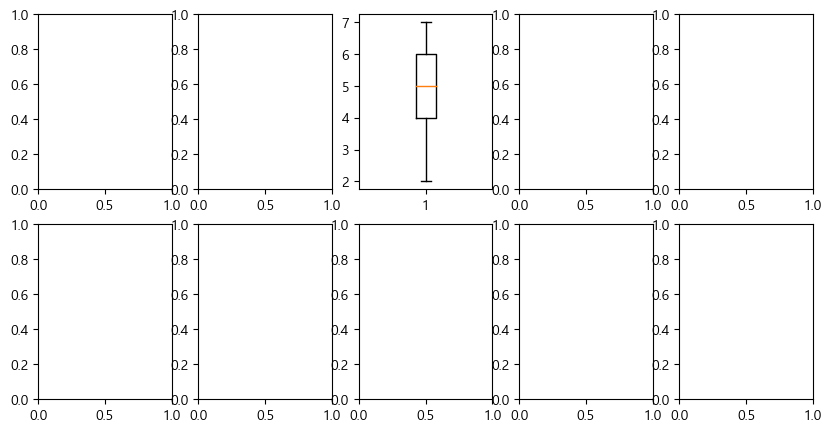

In [8]:
fig,ax = plt.subplots(2,5, figsize=(10,5))
ax[0,2].boxplot([2,4,5,6,7])

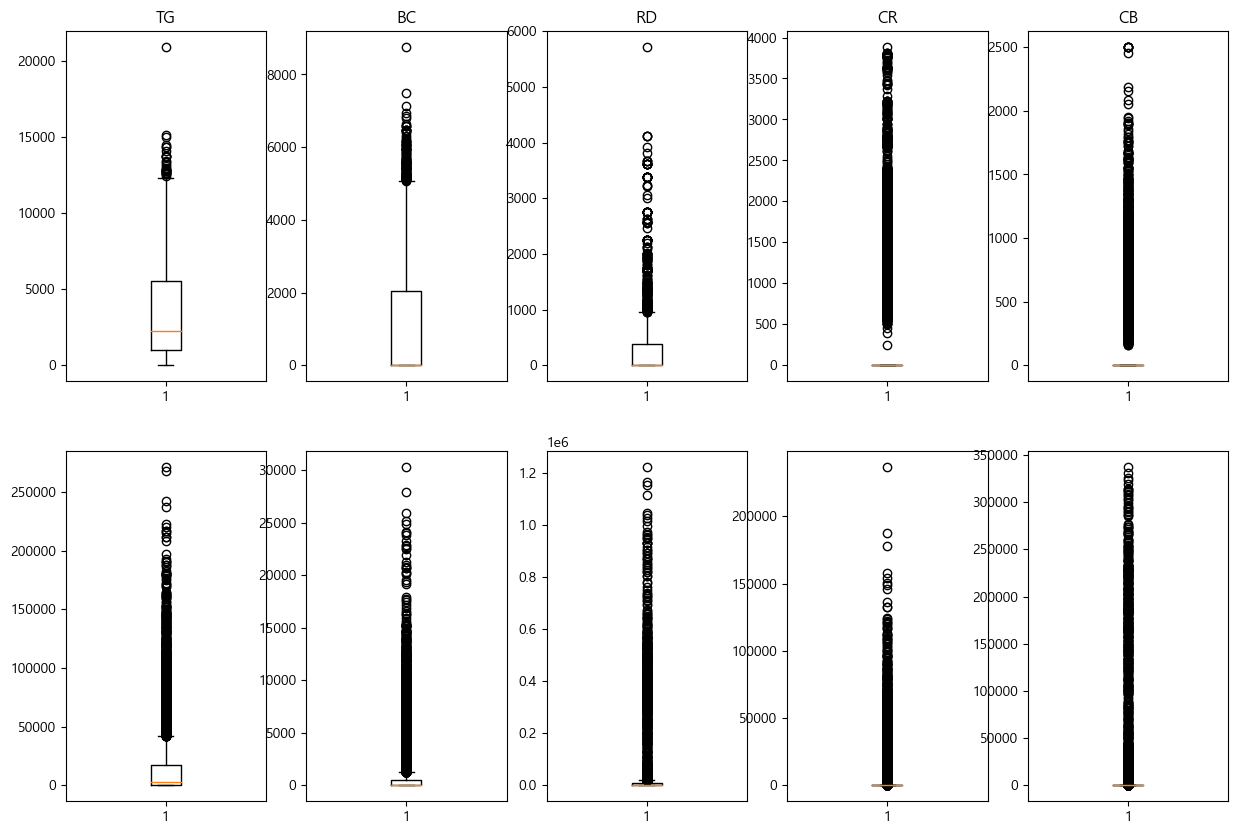

In [9]:
fig,ax = plt.subplots(2,5, figsize=(15,10))
for i , item in enumerate(train['item'].value_counts().index):
    ax[0,i].boxplot(train.loc[train['item']==item,['price']])
    ax[1,i].boxplot(train.loc[train['item']==item,['supply']])
    ax[0,i].set_title(item)
plt.show()

시간에 따른 품목별 가격 변화

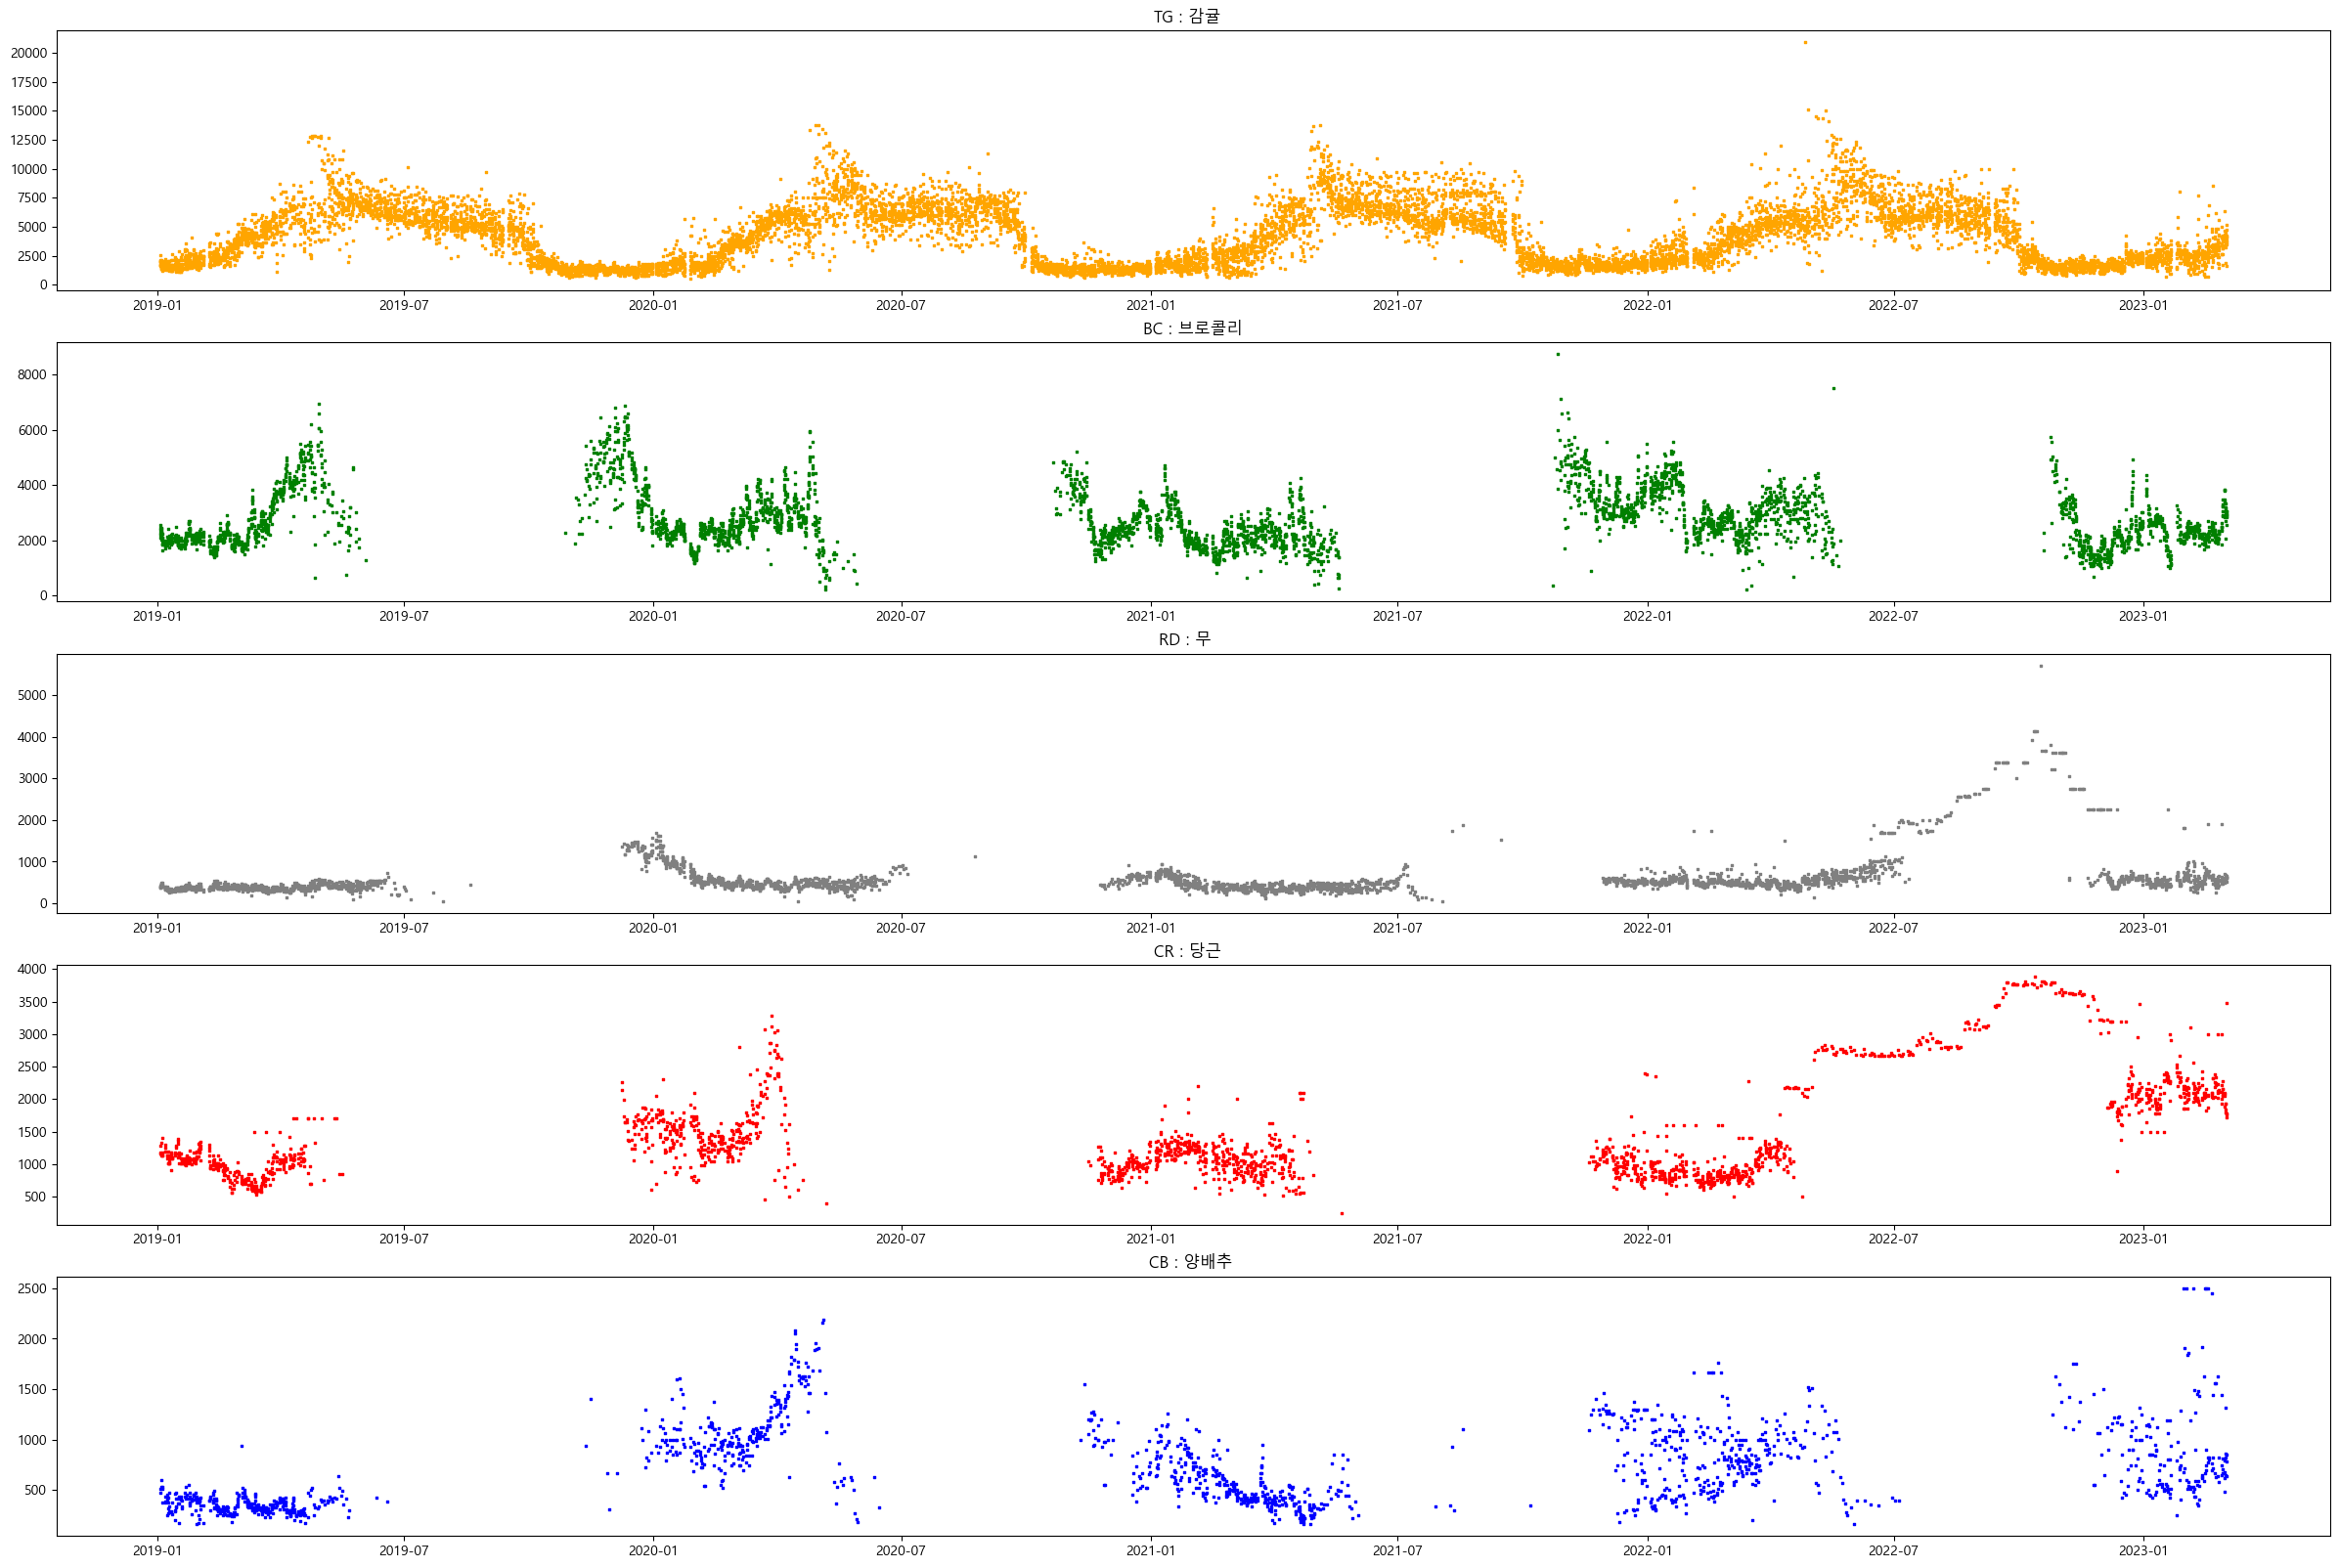

In [10]:
fig, ax = plt.subplots(5,1,figsize=(30,20))
# price가 0인 데이터는 삭제
TG_ = TG_price.loc[:,['timestamp','price']]
BC_ = BC_price.loc[:,['timestamp','price']]
RD_ = RD_price.loc[:,['timestamp','price']]
CR_ = CR_price.loc[:,['timestamp','price']]
CB_ = CB_price.loc[:,['timestamp','price']]

ax[0].scatter(TG_['timestamp'],TG_['price'],color='orange',marker=',',s=0.7)#,markerfacecolor='orange',markersize=0.5,linestyle=(0,(1,10)))
ax[0].set_title('TG : 감귤  ')
ax[1].scatter(BC_['timestamp'],BC_['price'],color='green' ,marker=',',s=0.7)#,markerfacecolor='green' ,markersize=0.5,linestyle=(0,(1,10)))
ax[1].set_title('BC : 브로콜리')
ax[2].scatter(RD_['timestamp'],RD_['price'],color='gray'  ,marker=',',s=0.7)#,markerfacecolor='gray'  ,markersize=0.5,linestyle=(0,(1,10)))
ax[2].set_title('RD : 무   ')
ax[3].scatter(CR_['timestamp'],CR_['price'],color='red'   ,marker=',',s=0.7)#,markerfacecolor='red'   ,markersize=0.5,linestyle=(0,(1,10)))
ax[3].set_title('CR : 당근  ')
ax[4].scatter(CB_['timestamp'],CB_['price'],color='blue'  ,marker=',',s=0.7)#,markerfacecolor='blue'  ,markersize=0.5,linestyle=(0,(1,10)))
ax[4].set_title('CB : 양배추 ')
plt.savefig('../graphs/시간별_품목별_가격.png')
plt.show()

- 감귤 : 전체적으로 고른 판매량을 보임.<br/>
가격도 규칙적인 패턴을 보임
<br/>

- 브로콜리 : 19년도에는 1\~7월 그 이후로는 계속 약 10월\~내년6월 규칙적인 판매량을 보임.<br/>
가격의 경우, 19,20년도는 아니지만, 21년부터는 규칙적인 패턴이 보임
<br/>

- 무 : 1~7월 사이 규칙적인 판매량, 안정적으로 낮은 가격대.
<br/> 규치적인 판매시기 외의 판매는 수입산 무이지 않을까 싶음
<br/>

- 당근 : 판매시기는 일부 규칙적. 가격은 거의 불규칙적.
<br/> 마찬가지로 기존 판매시기 외의 판매량은 수입산이지 않을까 >> 예상대로 해당 기간에 수입이 많았고, 무역수지가 적자였음
<br/>

- 양배추 : 제일 오락가락하는 패턴

In [11]:
# 무와 당근의 22년도 수입 기록을 확인해보자
# 무역 거래 datetime 설정
international_trade['기간'] = pd.to_datetime(international_trade['기간'],format='%Y-%m')
international_trade.tail()

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
1269,2023-02-01,포포(papaw)[파파야(papaya)],0,0,23830,71,-71
1270,2023-02-01,사과,135165,351,0,0,351
1271,2023-02-01,배,2206012,5411,1,0,5411
1272,2023-02-01,신 체리[프루너스 체라서스(Prunus cerasus)],5,0,0,0,0
1273,2023-02-01,자두,0,0,2,0,0


In [12]:
# regex = '무.*'
# rd_pattern = re.compile(regex)
# RD_international = international_trade[international_trade['품목명'].apply(
#         lambda x : False if (rd_pattern.match(x)==None) else True
#     )]
# RD_international.head()

'감귤'을 포함하는 모든 무역 거래 추출 (감귤만 있어서 따로 처리 x)

In [13]:
TG_international = international_trade[international_trade['품목명'].str.contains("감귤")]
print(TG_international['품목명'].value_counts())
TG_export = TG_international[['기간','수출 중량','수출 금액']]
TG_import = TG_international[['기간','수입 중량','수입 금액']]
TG_international.head()

품목명
감귤    50
Name: count, dtype: int64


,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
17,2019-01-01,감귤,58368,172,0,0,172
41,2019-02-01,감귤,8474,33,0,0,33
64,2019-03-01,감귤,2061,10,4599,12,-2
88,2019-04-01,감귤,328,9,13457,36,-27
114,2019-05-01,감귤,2560,21,0,0,21


'브로콜리'을 포함하는 모든 무역 거래 추출<br/> 
⚠️문제 : 양배추와 브로콜리가 같은 record로 기록됨... 어떻게 분리???

In [28]:
BC_international = international_trade[international_trade['품목명'].str.contains("브로")]
print(BC_international['품목명'].value_counts())
BC_export = BC_international[['기간','수출 중량','수출 금액']]
BC_import = BC_international[['기간','수입 중량','수입 금액']]
BC_international.head()

품목명
꽃양배추와 브로콜리(broccoli)    50
Name: count, dtype: int64


,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
3,2019-01-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
28,2019-02-01,꽃양배추와 브로콜리(broccoli),780,1,396870,399,-398
51,2019-03-01,꽃양배추와 브로콜리(broccoli),100,0,417756,503,-503
75,2019-04-01,꽃양배추와 브로콜리(broccoli),18,0,783593,1207,-1207
99,2019-05-01,꽃양배추와 브로콜리(broccoli),16,0,749745,1028,-1028


무의 경우, 무역 거래에 무화과와 순무가 존재. >> 순무만 추출

In [32]:
RD_international_not_precise = international_trade[international_trade['품목명'].str.contains('무')]
print(RD_international_not_precise['품목명'].value_counts())
RD_international = international_trade[international_trade['품목명']=='순무']
RD_export = RD_international[['기간','수출 중량','수출 금액']]
RD_import = RD_international[['기간','수입 중량','수입 금액']]
RD_international.head()

품목명
무화과    50
순무      6
Name: count, dtype: int64


,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
536,2020-10-01,순무,450,8,0,0,8
681,2021-04-01,순무,577,0,0,0,0
705,2021-05-01,순무,312,0,0,0,0
732,2021-06-01,순무,130,0,0,0,0
861,2021-11-01,순무,0,0,1,0,0


'당근'을 포함하는 모든 무역 거래 추출 (당근만 있어서 따로 처리 x)

In [16]:
CR_international = international_trade[international_trade['품목명'].str.contains("당근")]
print(CR_international['품목명'].value_counts())
CR_export = CR_international[['기간','수출 중량','수출 금액']]
CR_import = CR_international[['기간','수입 중량','수입 금액']]
CR_international.head()

품목명
당근    50
Name: count, dtype: int64


,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
8,2019-01-01,당근,23150,22,7466150,2955,-2934
33,2019-02-01,당근,16250,16,6524716,2600,-2585
56,2019-03-01,당근,17960,13,13353720,4953,-4941
80,2019-04-01,당근,16910,14,8323700,3493,-3479
104,2019-05-01,당근,18000,16,4897803,2160,-2144


'양배추'을 포함하는 모든 무역 거래 추출<br/> 
⚠️문제 : 양배추와 브로콜리가 같은 record로 기록됨... 어떻게 분리???

In [17]:
CB_international = international_trade[international_trade['품목명'].str.contains("양배추")]
print(CB_international['품목명'].value_counts())
CB_export = CB_international[['기간','수출 중량','수출 금액']]
CB_import = CB_international[['기간','수입 중량','수입 금액']]
CB_international.head()

품목명
꽃양배추와 브로콜리(broccoli)    50
방울다다기 양배추               50
양배추                     50
Name: count, dtype: int64


,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
3,2019-01-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01-01,방울다다기 양배추,0,0,7580,38,-38
5,2019-01-01,양배추,184650,94,395802,90,4
28,2019-02-01,꽃양배추와 브로콜리(broccoli),780,1,396870,399,-398
29,2019-02-01,방울다다기 양배추,0,0,4140,21,-21


In [18]:
# 무 : RD_international
# 당근 : CR_international

# 2022년 7월~ 23년 1월 사이의 무역거래 조회
rd_2022_inter = RD_international[RD_international['기간'].dt.year>=2022]
cr_2022_inter = CR_international[CR_international['기간'].dt.year>=2022]
rd_2022_inter

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
1254,2023-02-01,순무,4000,4,2,0,4


In [19]:
cr_2022_inter

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
911,2022-01-01,당근,34274,69,4402510,2916,-2847
937,2022-02-01,당근,16020,18,5573000,3789,-3772
964,2022-03-01,당근,17000,16,8673670,4056,-4040
989,2022-04-01,당근,14510,13,8141410,3794,-3781
1015,2022-05-01,당근,18500,19,7064500,3540,-3522
1043,2022-06-01,당근,2406,3,8812500,4618,-4616
1070,2022-07-01,당근,24700,19,8389500,3817,-3798
1098,2022-08-01,당근,15536,13,7106000,3063,-3050
1127,2022-09-01,당근,23500,19,11543000,4875,-4857
1153,2022-10-01,당근,11560,10,9396700,3727,-3718


<span style='color:blue'> 
무역 수입 및 수출 시각화
    ⚠️문제 : 수출입 중량은 있는데 가격이 0원인 경우가 있음.
</span>

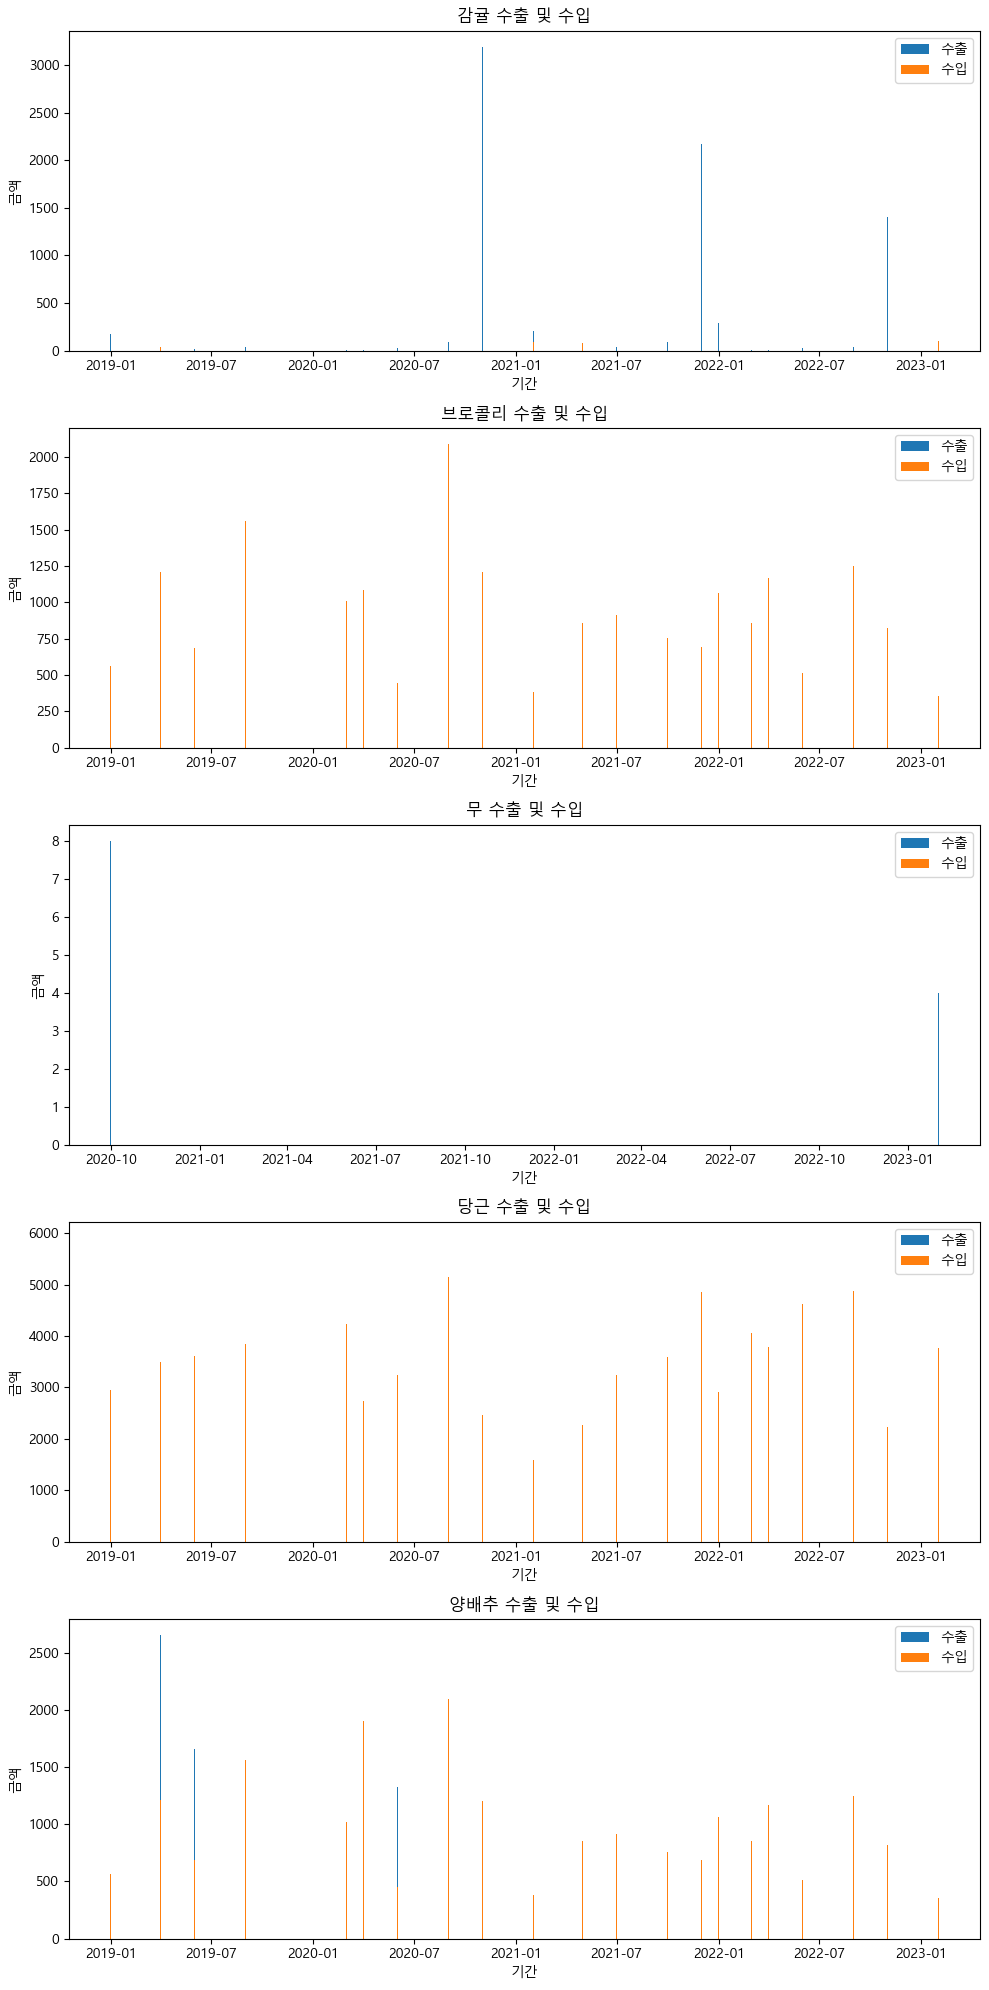

In [20]:
fig, ax = plt.subplots(5, 1, figsize=(10, 20))

# 감귤
ax[0].bar(TG_export['기간'], TG_export['수출 금액'], label='수출')
ax[0].bar(TG_import['기간'], TG_import['수입 금액'], label='수입')
ax[0].set_title('감귤 수출 및 수입')
ax[0].set_xlabel('기간')
ax[0].set_ylabel('금액')
ax[0].legend()

# 브로콜리
ax[1].bar(BC_export['기간'], BC_export['수출 금액'], label='수출')
ax[1].bar(BC_import['기간'], BC_import['수입 금액'], label='수입')
ax[1].set_title('브로콜리 수출 및 수입')
ax[1].set_xlabel('기간')
ax[1].set_ylabel('금액')
ax[1].legend()

# 무
ax[2].bar(RD_export['기간'], RD_export['수출 금액'], label='수출')
ax[2].bar(RD_import['기간'], RD_import['수입 금액'], label='수입')
ax[2].set_title('무 수출 및 수입')
ax[2].set_xlabel('기간')
ax[2].set_ylabel('금액')
ax[2].legend()

# 당근
ax[3].bar(CR_export['기간'], CR_export['수출 금액'], label='수출')
ax[3].bar(CR_import['기간'], CR_import['수입 금액'], label='수입')
ax[3].set_title('당근 수출 및 수입')
ax[3].set_xlabel('기간')
ax[3].set_ylabel('금액')
ax[3].legend()

# 양배추
ax[4].bar(CB_export['기간'], CB_export['수출 금액'], label='수출')
ax[4].bar(CB_import['기간'], CB_import['수입 금액'], label='수입')
ax[4].set_title('양배추 수출 및 수입')
ax[4].set_xlabel('기간')
ax[4].set_ylabel('금액')
ax[4].legend()

plt.tight_layout()
plt.savefig('../graphs/international_trade.png')
plt.show()


#### 시간별 거래량 추이

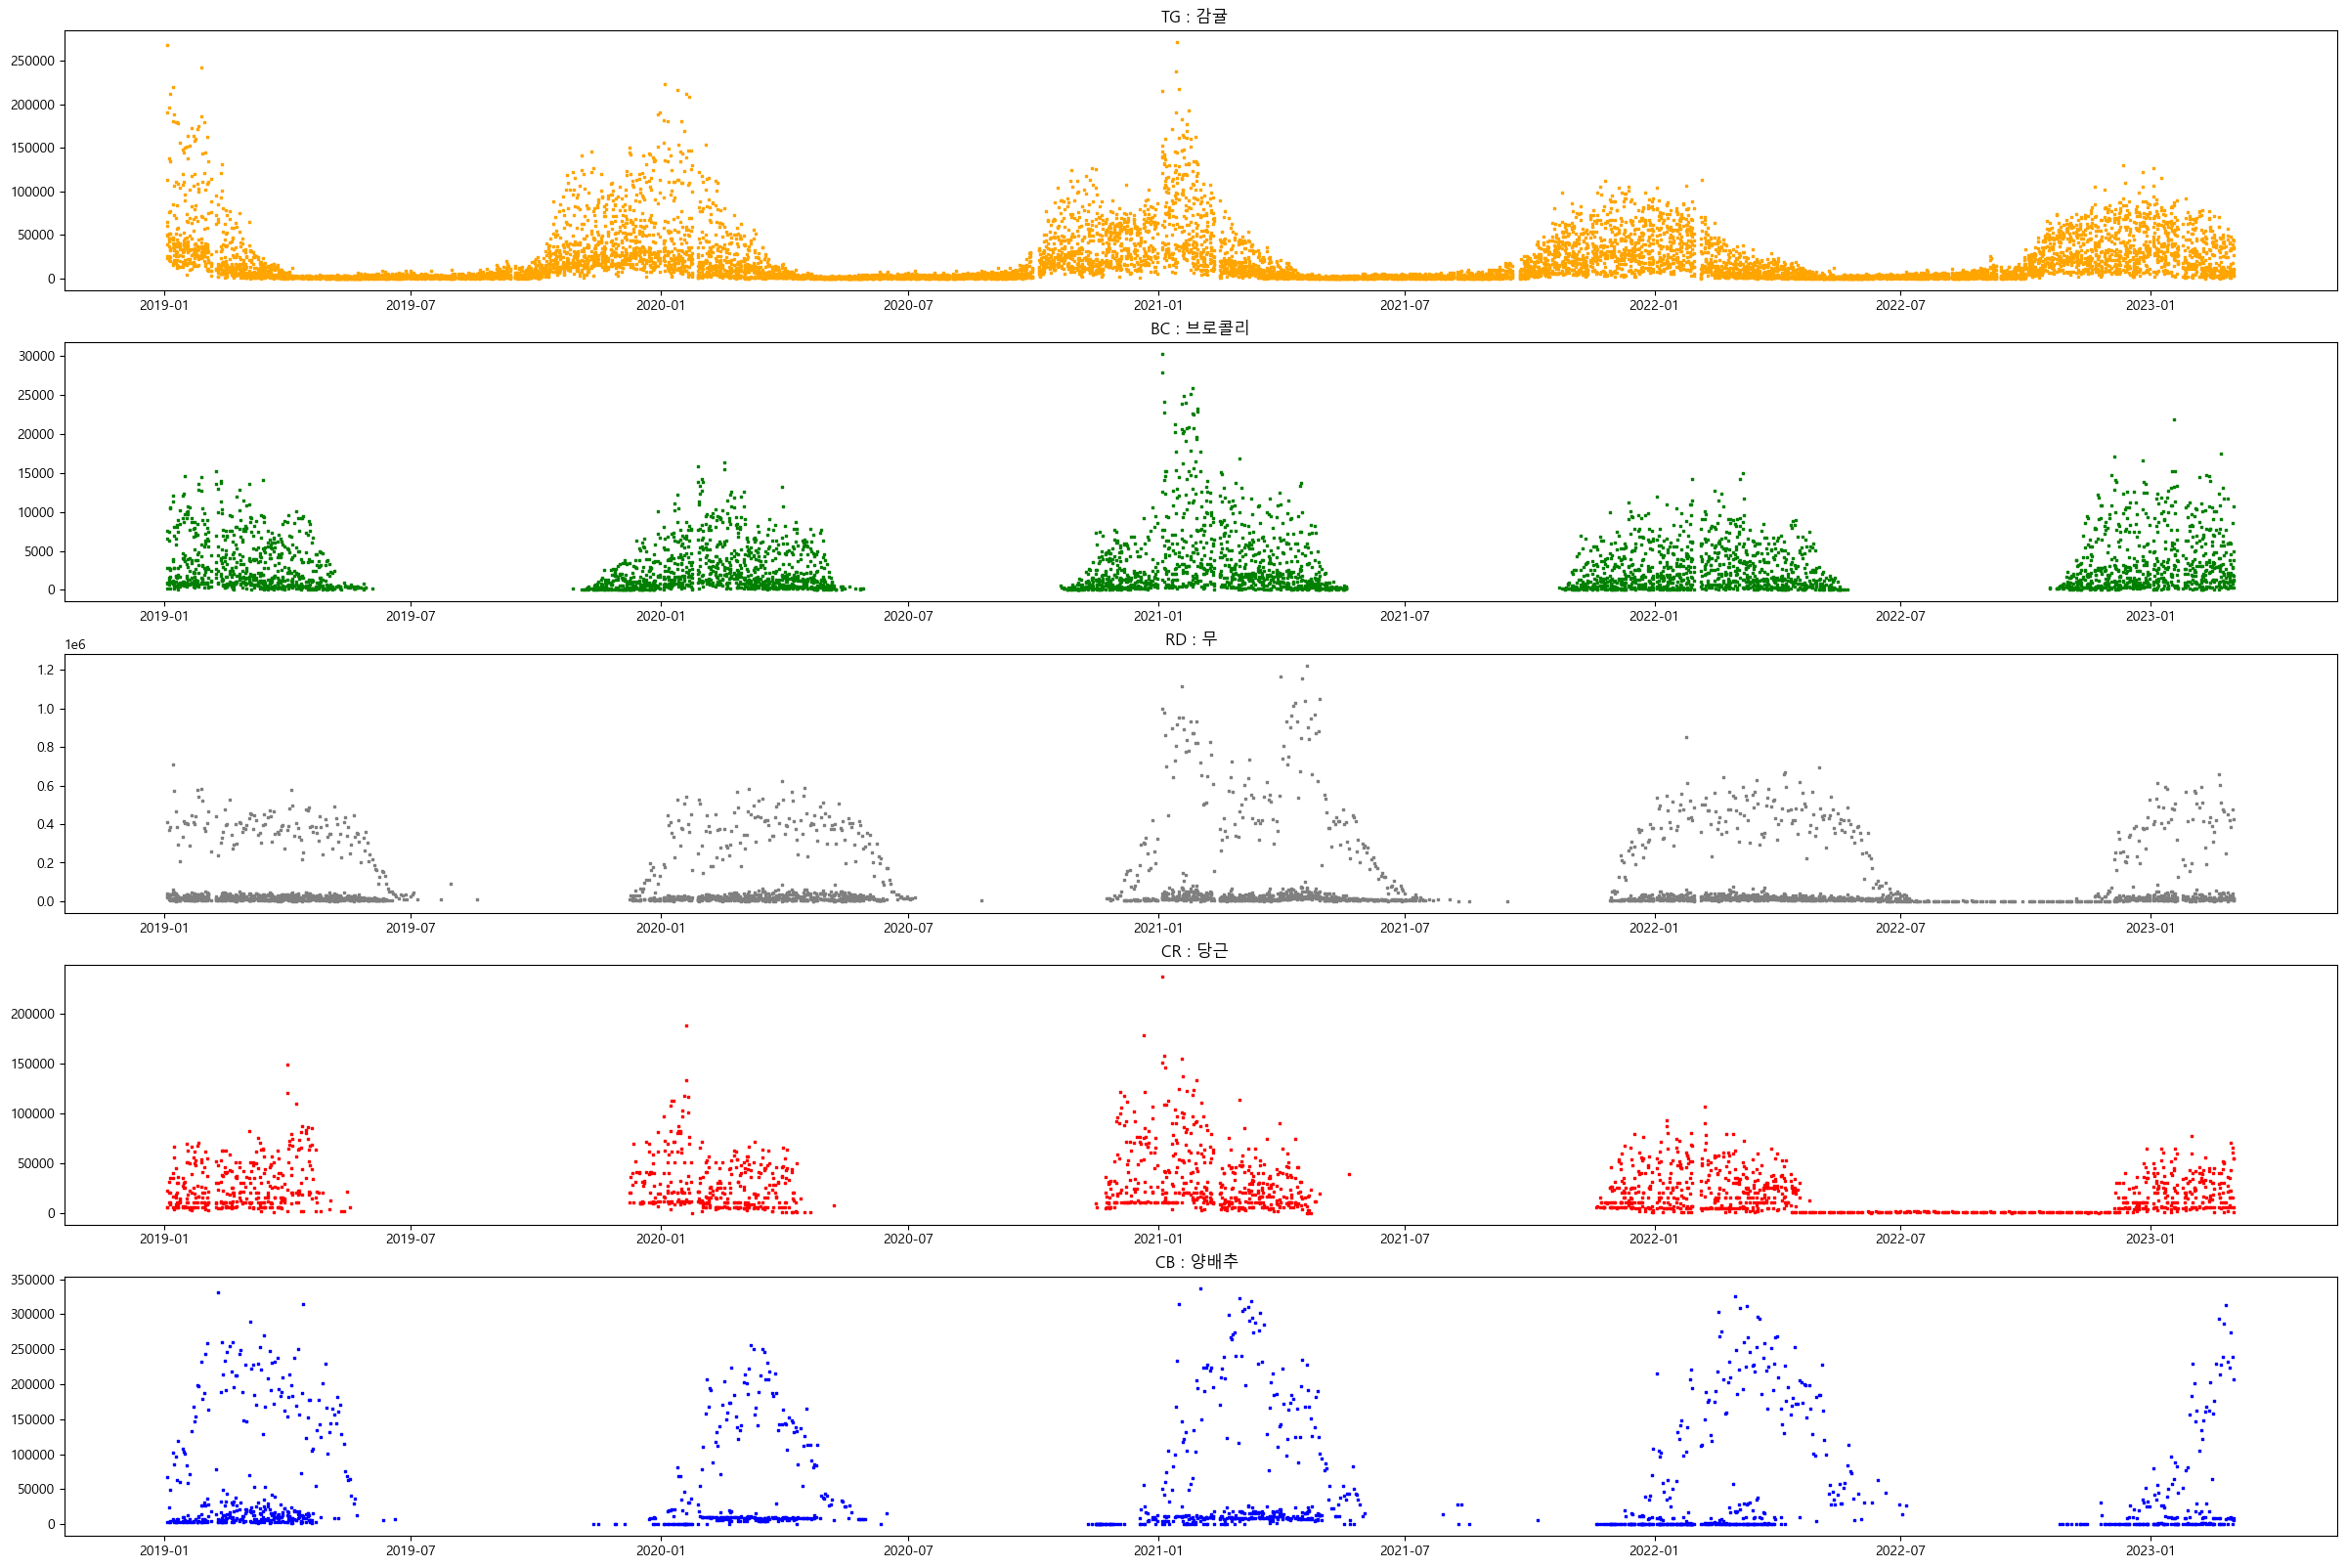

In [21]:
fig, ax = plt.subplots(5,1,figsize=(30,20))
# price가 0인 데이터는 삭제
TG_ = TG[TG['supply']>0]
BC_ = BC[BC['supply']>0]
RD_ = RD[RD['supply']>0]
CR_ = CR[CR['supply']>0]
CB_ = CB[CB['supply']>0]

ax[0].scatter(TG_['timestamp'],TG_['supply'],color='orange',marker=',',s=0.7)#,markerfacecolor='orange',markersize=0.5,linestyle=(0,(1,10)))
ax[0].set_title('TG : 감귤  ')
ax[1].scatter(BC_['timestamp'],BC_['supply'],color='green' ,marker=',',s=0.7)#,markerfacecolor='green' ,markersize=0.5,linestyle=(0,(1,10)))
ax[1].set_title('BC : 브로콜리')
ax[2].scatter(RD_['timestamp'],RD_['supply'],color='gray'  ,marker=',',s=0.7)#,markerfacecolor='gray'  ,markersize=0.5,linestyle=(0,(1,10)))
ax[2].set_title('RD : 무   ')
ax[3].scatter(CR_['timestamp'],CR_['supply'],color='red'   ,marker=',',s=0.7)#,markerfacecolor='red'   ,markersize=0.5,linestyle=(0,(1,10)))
ax[3].set_title('CR : 당근  ')
ax[4].scatter(CB_['timestamp'],CB_['supply'],color='blue'  ,marker=',',s=0.7)#,markerfacecolor='blue'  ,markersize=0.5,linestyle=(0,(1,10)))
ax[4].set_title('CB : 양배추 ')

# ax0 = ax[0].twinx()


plt.savefig('../graphs/시간별_품목별_거래량.png')
plt.show()

휴일 가격 확인


In [22]:
train[train['dayofweek'].isin([5,6])].groupby('item')['price'].describe()
#.agg(['min','mean','std'])


,count,mean,std,min,25%,50%,75%,max
item,,,,,,,,
BC,3906.0,519.574501,1164.011419,0.0,0.0,0.0,0.0,6588.0
CB,2170.0,79.742857,251.948444,0.0,0.0,0.0,0.0,1821.0
CR,3038.0,88.740290,339.475991,0.0,0.0,0.0,0.0,3282.0
RD,3472.0,79.334101,194.856008,0.0,0.0,0.0,0.0,1630.0
TG,4340.0,1704.664747,2531.419889,0.0,0.0,0.0,2613.5,14109.0
